In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./data')

In [5]:
# define transformation
ds_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,))
])

In [6]:
# load MNIST dataset
train_ds = datasets.MNIST('./data',train=True, download=False, transform=ds_transform)
val_ds = datasets.MNIST('./data',train=False, download=False, transform=ds_transform)

In [8]:
# define data loader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 128, shuffle=True)

torch.Size([64, 1, 28, 28]) torch.Size([64])


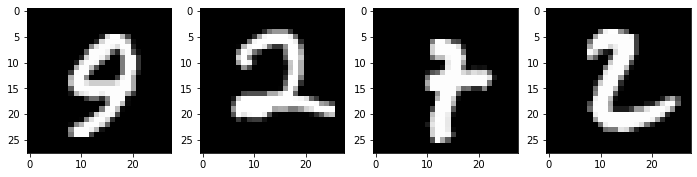

In [9]:
# check sample image
for x, y in train_dl:
    print(x.shape, y.shape)
    break

num = 4
img = x[:num]

plt.figure(figsize=(15,15))
for i in range(num):
    plt.subplot(1,num+1,i+1)
    plt.imshow(to_pil_image(0.1307*img[i]+0.3081), cmap='gray')

## Defining Teacher Model
For knowledge distillation, the teacher model to obtain soft labels must first be trained. Therefore, we define the teacher model.

In [10]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1200)
        self.bn1 = nn.BatchNorm1d(1200)
        self.fc2 = nn.Linear(1200,1200)
        self.bn2 = nn.BatchNorm1d(1200)
        self.fc3 = nn.Linear(1200, 10)
    
    def forward(self,x):
        x = x.view(-1,28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.dropout(x,p=0.8)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x,p=0.8)
        x = self.fc3(x)
        return x
        

In [11]:
# check
x = torch.randn(16,1,28,28).to(device)
teacher = Teacher().to(device)
output = teacher(x)
print(output.shape)

torch.Size([16, 10])


In [12]:
# weight initialization
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

teacher.apply(initialize_weights);


### Training Teacher Model

In [13]:
# loss function
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(teacher.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [14]:
# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [15]:
# set hyper parameters
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createFolder('./models')

In [16]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

Epoch 0/29, current lr= 0.001
Copied best model weights!
train loss: 0.007353, val loss: 0.002246, accuracy: 91.17, time: 0.2485 min
----------
Epoch 1/29, current lr= 0.001
Copied best model weights!
train loss: 0.004790, val loss: 0.001926, accuracy: 92.83, time: 0.4951 min
----------
Epoch 2/29, current lr= 0.001
Copied best model weights!
train loss: 0.004116, val loss: 0.001730, accuracy: 92.87, time: 0.7387 min
----------
Epoch 3/29, current lr= 0.001
Copied best model weights!
train loss: 0.003814, val loss: 0.001570, accuracy: 94.07, time: 0.9844 min
----------
Epoch 4/29, current lr= 0.001
train loss: 0.003458, val loss: 0.001584, accuracy: 93.92, time: 1.2226 min
----------
Epoch 5/29, current lr= 0.001
Copied best model weights!
train loss: 0.003322, val loss: 0.001524, accuracy: 94.18, time: 1.4594 min
----------
Epoch 6/29, current lr= 0.001
Copied best model weights!
train loss: 0.003144, val loss: 0.001449, accuracy: 94.82, time: 1.6981 min
----------
Epoch 7/29, current

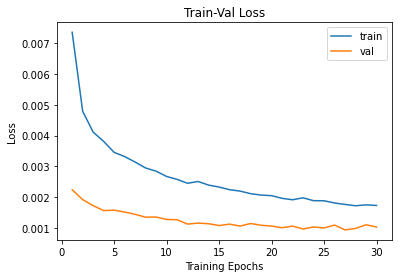

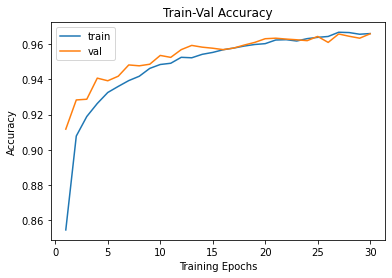

In [17]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

## Define Student Model
Now we define the student model to transfer the teacher's knowledge.

In [18]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800,800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800,10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [19]:
# check
x = torch.randn(16,1,28,28).to(device)
student = Student().to(device)
output = student(x)
print(output.shape)

torch.Size([16, 10])


In [20]:
# weight initialization
student.apply(initialize_weights);

## Knowledge distillation
Now we train the student model with knowledge distillation loss using the soft label of the teacher model.

In [22]:
teacher = Teacher().to(device)
# load weight
teacher.load_state_dict(torch.load('./models/teacher_weights.pt'))

student = Student().to(device)

# optimizer
opt = optim.Adam(student.parameters())

![loss functions](images/loss.jpg)

In [23]:
#knowledge distillation loss
def distillation(y,labels,teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y : student
    # labeks : hard labels
    # teacher_scores : soft labels
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

In [24]:
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

In [26]:
### training for 100 epochs

num_epochs= 100

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in tqdm(train_dl):
        xb = xb.to(device)
        yb = yb.to(device)

        output = student(xb)
        teacher_output = teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(student, loss_func, val_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

  0%|                                                                                          | 0/938 [00:00<?, ?it/s]<ipython-input-23-db5fd09c49c0>:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
<ipython-input-23-db5fd09c49c0>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
C:\anaconda3\lib\site-packages\torch\nn\functional.py:2741: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'ba

Epoch 0/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 53.05it/s]

train loss: 0.032339, val loss: 0.000883, accuracy: 97.07, time: 0.2690 min
----------
Epoch 1/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:15, 59.09it/s]

train loss: 0.028081, val loss: 0.000720, accuracy: 97.60, time: 0.5342 min
----------
Epoch 2/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:14, 63.21it/s]

train loss: 0.027511, val loss: 0.000631, accuracy: 97.80, time: 0.8003 min
----------
Epoch 3/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:16, 55.04it/s]

train loss: 0.027303, val loss: 0.000635, accuracy: 97.75, time: 1.0598 min
----------
Epoch 4/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 57.17it/s]

train loss: 0.027176, val loss: 0.000569, accuracy: 97.99, time: 1.3281 min
----------
Epoch 5/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 61.47it/s]

train loss: 0.026948, val loss: 0.000626, accuracy: 97.83, time: 1.5984 min
----------
Epoch 6/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 55.87it/s]

train loss: 0.026853, val loss: 0.000587, accuracy: 97.99, time: 1.8625 min
----------
Epoch 7/99, current lr= 0.001


  1%|█                                                                                | 12/938 [00:00<00:16, 56.52it/s]

train loss: 0.026792, val loss: 0.000569, accuracy: 97.98, time: 2.1334 min
----------
Epoch 8/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 48.55it/s]

train loss: 0.026791, val loss: 0.000552, accuracy: 98.00, time: 2.4004 min
----------
Epoch 9/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:16, 57.64it/s]

train loss: 0.026596, val loss: 0.000550, accuracy: 97.99, time: 2.6994 min
----------
Epoch 10/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 47.60it/s]

train loss: 0.026606, val loss: 0.000541, accuracy: 98.01, time: 2.9684 min
----------
Epoch 11/99, current lr= 0.001


  1%|█                                                                                | 12/938 [00:00<00:16, 55.93it/s]

train loss: 0.026511, val loss: 0.000520, accuracy: 98.06, time: 3.2428 min
----------
Epoch 12/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 56.03it/s]

train loss: 0.026378, val loss: 0.000541, accuracy: 98.08, time: 3.5094 min
----------
Epoch 13/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 56.46it/s]

train loss: 0.026472, val loss: 0.000535, accuracy: 97.95, time: 3.7891 min
----------
Epoch 14/99, current lr= 0.001


  1%|▋                                                                                 | 8/938 [00:00<00:13, 69.37it/s]

train loss: 0.026493, val loss: 0.000564, accuracy: 97.95, time: 4.0623 min
----------
Epoch 15/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 52.86it/s]

train loss: 0.026424, val loss: 0.000509, accuracy: 98.12, time: 4.3169 min
----------
Epoch 16/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:18, 50.36it/s]

train loss: 0.026337, val loss: 0.000546, accuracy: 98.12, time: 4.5724 min
----------
Epoch 17/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.57it/s]

train loss: 0.026386, val loss: 0.000554, accuracy: 98.17, time: 4.8291 min
----------
Epoch 18/99, current lr= 0.001


  1%|▊                                                                                | 10/938 [00:00<00:19, 48.52it/s]

train loss: 0.026260, val loss: 0.000510, accuracy: 98.24, time: 5.1049 min
----------
Epoch 19/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 58.22it/s]

train loss: 0.026169, val loss: 0.000544, accuracy: 98.18, time: 5.3755 min
----------
Epoch 20/99, current lr= 0.001


  1%|▊                                                                                | 10/938 [00:00<00:19, 48.73it/s]

train loss: 0.026254, val loss: 0.000496, accuracy: 98.19, time: 5.6559 min
----------
Epoch 21/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 61.03it/s]

train loss: 0.026231, val loss: 0.000514, accuracy: 98.21, time: 5.9154 min
----------
Epoch 22/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 52.63it/s]

train loss: 0.026232, val loss: 0.000539, accuracy: 98.20, time: 6.1805 min
----------
Epoch 23/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 48.97it/s]

train loss: 0.026114, val loss: 0.000514, accuracy: 98.22, time: 6.4486 min
----------
Epoch 24/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:18, 51.69it/s]

train loss: 0.026227, val loss: 0.000466, accuracy: 98.34, time: 6.7187 min
----------
Epoch 25/99, current lr= 0.001


  1%|█                                                                                | 12/938 [00:00<00:15, 57.95it/s]

train loss: 0.026115, val loss: 0.000469, accuracy: 98.24, time: 6.9875 min
----------
Epoch 26/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 47.19it/s]

train loss: 0.026189, val loss: 0.000479, accuracy: 98.24, time: 7.2498 min
----------
Epoch 27/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 55.05it/s]

train loss: 0.026043, val loss: 0.000508, accuracy: 98.29, time: 7.5226 min
----------
Epoch 28/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 55.08it/s]

train loss: 0.026048, val loss: 0.000485, accuracy: 98.22, time: 7.7857 min
----------
Epoch 29/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:14, 63.64it/s]

train loss: 0.026018, val loss: 0.000484, accuracy: 98.35, time: 8.0520 min
----------
Epoch 30/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:18, 50.40it/s]

train loss: 0.025975, val loss: 0.000472, accuracy: 98.29, time: 8.3215 min
----------
Epoch 31/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:15, 58.25it/s]

train loss: 0.026135, val loss: 0.000480, accuracy: 98.25, time: 8.5751 min
----------
Epoch 32/99, current lr= 0.001


  1%|█                                                                                | 12/938 [00:00<00:16, 57.68it/s]

train loss: 0.025925, val loss: 0.000453, accuracy: 98.39, time: 8.8297 min
----------
Epoch 33/99, current lr= 0.001


  1%|█                                                                                | 12/938 [00:00<00:16, 57.08it/s]

train loss: 0.026056, val loss: 0.000476, accuracy: 98.35, time: 9.0830 min
----------
Epoch 34/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:14, 66.04it/s]

train loss: 0.026086, val loss: 0.000495, accuracy: 98.21, time: 9.3420 min
----------
Epoch 35/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 61.95it/s]

train loss: 0.026076, val loss: 0.000454, accuracy: 98.25, time: 9.5953 min
----------
Epoch 36/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 59.83it/s]

train loss: 0.025991, val loss: 0.000477, accuracy: 98.36, time: 9.8676 min
----------
Epoch 37/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 57.19it/s]

train loss: 0.025907, val loss: 0.000476, accuracy: 98.25, time: 10.1260 min
----------
Epoch 38/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 60.72it/s]

train loss: 0.025849, val loss: 0.000460, accuracy: 98.29, time: 10.3879 min
----------
Epoch 39/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 57.05it/s]

train loss: 0.025946, val loss: 0.000469, accuracy: 98.36, time: 10.6418 min
----------
Epoch 40/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 61.35it/s]

train loss: 0.025981, val loss: 0.000459, accuracy: 98.32, time: 10.8917 min
----------
Epoch 41/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:14, 62.69it/s]

train loss: 0.025976, val loss: 0.000482, accuracy: 98.24, time: 11.1437 min
----------
Epoch 42/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:14, 62.63it/s]

train loss: 0.026089, val loss: 0.000471, accuracy: 98.28, time: 11.3945 min
----------
Epoch 43/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 52.96it/s]

train loss: 0.026007, val loss: 0.000493, accuracy: 98.22, time: 11.6448 min
----------
Epoch 44/99, current lr= 0.001


  1%|█                                                                                | 12/938 [00:00<00:16, 56.95it/s]

train loss: 0.025859, val loss: 0.000467, accuracy: 98.27, time: 11.9081 min
----------
Epoch 45/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 52.16it/s]

train loss: 0.025770, val loss: 0.000485, accuracy: 98.23, time: 12.1931 min
----------
Epoch 46/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 55.07it/s]

train loss: 0.025943, val loss: 0.000478, accuracy: 98.26, time: 12.4709 min
----------
Epoch 47/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:18, 51.28it/s]

train loss: 0.025807, val loss: 0.000451, accuracy: 98.32, time: 12.7519 min
----------
Epoch 48/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 47.58it/s]

train loss: 0.025648, val loss: 0.000455, accuracy: 98.26, time: 13.0215 min
----------
Epoch 49/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 47.96it/s]

train loss: 0.025976, val loss: 0.000476, accuracy: 98.29, time: 13.3104 min
----------
Epoch 50/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:14, 65.46it/s]

train loss: 0.025976, val loss: 0.000466, accuracy: 98.26, time: 13.5731 min
----------
Epoch 51/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 57.69it/s]

train loss: 0.025748, val loss: 0.000467, accuracy: 98.30, time: 13.8359 min
----------
Epoch 52/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:13, 67.31it/s]

train loss: 0.025929, val loss: 0.000456, accuracy: 98.27, time: 14.1052 min
----------
Epoch 53/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.58it/s]

train loss: 0.025665, val loss: 0.000469, accuracy: 98.37, time: 14.3663 min
----------
Epoch 54/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 61.40it/s]

train loss: 0.025820, val loss: 0.000465, accuracy: 98.34, time: 14.6335 min
----------
Epoch 55/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 61.40it/s]

train loss: 0.025826, val loss: 0.000486, accuracy: 98.32, time: 14.8990 min
----------
Epoch 56/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 46.75it/s]

train loss: 0.025734, val loss: 0.000457, accuracy: 98.30, time: 15.1673 min
----------
Epoch 57/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 48.54it/s]

train loss: 0.025893, val loss: 0.000457, accuracy: 98.34, time: 15.4295 min
----------
Epoch 58/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.55it/s]

train loss: 0.025871, val loss: 0.000469, accuracy: 98.28, time: 15.7102 min
----------
Epoch 59/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 60.87it/s]

train loss: 0.025713, val loss: 0.000452, accuracy: 98.35, time: 15.9657 min
----------
Epoch 60/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:15, 58.26it/s]

train loss: 0.025752, val loss: 0.000476, accuracy: 98.27, time: 16.2252 min
----------
Epoch 61/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 47.56it/s]

train loss: 0.025698, val loss: 0.000448, accuracy: 98.29, time: 16.4893 min
----------
Epoch 62/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 53.57it/s]

train loss: 0.025909, val loss: 0.000458, accuracy: 98.31, time: 16.7653 min
----------
Epoch 63/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.05it/s]

train loss: 0.025779, val loss: 0.000466, accuracy: 98.27, time: 17.0467 min
----------
Epoch 64/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 55.37it/s]

train loss: 0.025650, val loss: 0.000464, accuracy: 98.36, time: 17.3195 min
----------
Epoch 65/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 59.32it/s]

train loss: 0.025646, val loss: 0.000461, accuracy: 98.35, time: 17.5945 min
----------
Epoch 66/99, current lr= 0.001


  1%|▋                                                                                 | 8/938 [00:00<00:24, 38.44it/s]

train loss: 0.025821, val loss: 0.000459, accuracy: 98.34, time: 17.8682 min
----------
Epoch 67/99, current lr= 0.001


  1%|█                                                                                | 12/938 [00:00<00:16, 55.59it/s]

train loss: 0.025583, val loss: 0.000441, accuracy: 98.36, time: 18.1482 min
----------
Epoch 68/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 52.63it/s]

train loss: 0.025807, val loss: 0.000468, accuracy: 98.35, time: 18.4076 min
----------
Epoch 69/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 58.82it/s]

train loss: 0.025821, val loss: 0.000478, accuracy: 98.37, time: 18.6807 min
----------
Epoch 70/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 52.19it/s]

train loss: 0.025650, val loss: 0.000453, accuracy: 98.32, time: 18.9424 min
----------
Epoch 71/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:18, 49.48it/s]

train loss: 0.025785, val loss: 0.000579, accuracy: 98.38, time: 19.2072 min
----------
Epoch 72/99, current lr= 0.001


  1%|█                                                                                | 12/938 [00:00<00:16, 54.59it/s]

train loss: 0.025650, val loss: 0.000467, accuracy: 98.28, time: 19.4760 min
----------
Epoch 73/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.54it/s]

train loss: 0.025752, val loss: 0.000470, accuracy: 98.26, time: 19.7356 min
----------
Epoch 74/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:15, 59.69it/s]

train loss: 0.025699, val loss: 0.000461, accuracy: 98.27, time: 20.0000 min
----------
Epoch 75/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.06it/s]

train loss: 0.025697, val loss: 0.000469, accuracy: 98.38, time: 20.2718 min
----------
Epoch 76/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:15, 58.82it/s]

train loss: 0.025617, val loss: 0.000453, accuracy: 98.33, time: 20.5378 min
----------
Epoch 77/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 53.10it/s]

train loss: 0.025789, val loss: 0.000456, accuracy: 98.33, time: 20.8133 min
----------
Epoch 78/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 48.05it/s]

train loss: 0.025694, val loss: 0.000446, accuracy: 98.38, time: 21.0847 min
----------
Epoch 79/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:14, 64.81it/s]

train loss: 0.025642, val loss: 0.000454, accuracy: 98.38, time: 21.3486 min
----------
Epoch 80/99, current lr= 0.001


  0%|▎                                                                                 | 4/938 [00:00<00:24, 38.55it/s]

train loss: 0.025791, val loss: 0.000468, accuracy: 98.37, time: 21.6145 min
----------
Epoch 81/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.07it/s]

train loss: 0.025719, val loss: 0.000455, accuracy: 98.33, time: 21.8892 min
----------
Epoch 82/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 53.57it/s]

train loss: 0.025663, val loss: 0.000462, accuracy: 98.30, time: 22.1607 min
----------
Epoch 83/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.05it/s]

train loss: 0.025632, val loss: 0.000459, accuracy: 98.31, time: 22.4228 min
----------
Epoch 84/99, current lr= 0.001


  1%|▊                                                                                | 10/938 [00:00<00:19, 47.53it/s]

train loss: 0.025780, val loss: 0.000456, accuracy: 98.35, time: 22.6977 min
----------
Epoch 85/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 59.85it/s]

train loss: 0.025735, val loss: 0.000460, accuracy: 98.33, time: 22.9666 min
----------
Epoch 86/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:19, 49.03it/s]

train loss: 0.025580, val loss: 0.000449, accuracy: 98.34, time: 23.2384 min
----------
Epoch 87/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 52.17it/s]

train loss: 0.025818, val loss: 0.000445, accuracy: 98.40, time: 23.5066 min
----------
Epoch 88/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 52.17it/s]

train loss: 0.025679, val loss: 0.000450, accuracy: 98.26, time: 23.7800 min
----------
Epoch 89/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 56.69it/s]

train loss: 0.025774, val loss: 0.000474, accuracy: 98.24, time: 24.0580 min
----------
Epoch 90/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.05it/s]

train loss: 0.025553, val loss: 0.000457, accuracy: 98.41, time: 24.3430 min
----------
Epoch 91/99, current lr= 0.001


  1%|█                                                                                | 12/938 [00:00<00:16, 57.62it/s]

train loss: 0.025748, val loss: 0.000448, accuracy: 98.41, time: 24.6025 min
----------
Epoch 92/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:14, 64.22it/s]

train loss: 0.025676, val loss: 0.000447, accuracy: 98.22, time: 24.8615 min
----------
Epoch 93/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:17, 54.55it/s]

train loss: 0.025688, val loss: 0.000457, accuracy: 98.37, time: 25.1334 min
----------
Epoch 94/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:18, 50.87it/s]

train loss: 0.025741, val loss: 0.000453, accuracy: 98.30, time: 25.4034 min
----------
Epoch 95/99, current lr= 0.001


  1%|▍                                                                                 | 5/938 [00:00<00:18, 50.00it/s]

train loss: 0.025665, val loss: 0.000451, accuracy: 98.33, time: 25.6750 min
----------
Epoch 96/99, current lr= 0.001


  1%|▉                                                                                | 11/938 [00:00<00:18, 50.66it/s]

train loss: 0.025655, val loss: 0.000458, accuracy: 98.35, time: 25.9504 min
----------
Epoch 97/99, current lr= 0.001


  1%|▌                                                                                 | 7/938 [00:00<00:15, 60.84it/s]

train loss: 0.025631, val loss: 0.000475, accuracy: 98.33, time: 26.2193 min
----------
Epoch 98/99, current lr= 0.001


  1%|▌                                                                                 | 6/938 [00:00<00:16, 55.55it/s]

train loss: 0.025657, val loss: 0.000463, accuracy: 98.24, time: 26.4816 min
----------
Epoch 99/99, current lr= 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 63.23it/s]


train loss: 0.025665, val loss: 0.000455, accuracy: 98.29, time: 26.7540 min
----------


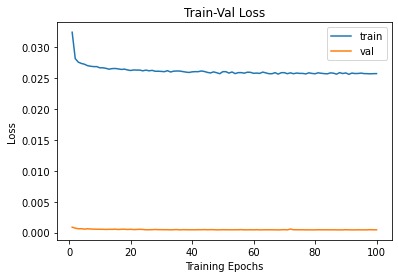

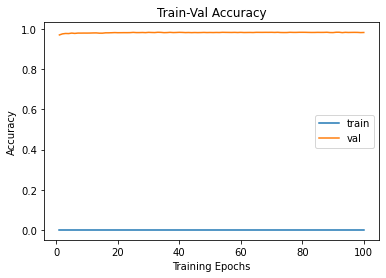

In [35]:
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_history['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_history['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_history['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_history['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [36]:
torch.save(student.state_dict(),'./models/student_weights.pt')